In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import os.path
import numpy as np
from glob import glob
import random
import cv2

TRAINING_DIR = '../lyft_training_data/Train/'
RGB_DIR = 'CameraRGB'
SEG_DIR = 'CameraSeg'

# width, height
IMAGE_SIZE = (224, 224)

# 0: nothing, 1: road + roadlines, 2: vehicles
SEG_MAP = {
    6: 1, 7: 1,
    10: 2
}

def cut_hood(img, perc_retain=0.9):
    """
    Cut the hood part of the car
    :param img: The image
    """
    height = img.shape[0]
    return img[0:int(height*perc_retain), :]

def remap_seg(seg, seg_map):
    """
    Re-map segmentation image
    :param seg: Segmentation image, 2-dimensional [width:height]
    :param seg_map: dict object, mapping of old_id to new_id,
                    unmapped ids are converted to 0.
    """
    keys = list(seg_map.keys())
    
    # Convert unmapped cells
    seg[~np.isin(seg, keys)] = 0
    
    # Convert cells with relevant keys
    for key in keys:
        seg[seg == key] = seg_map[key]
    return seg

def seg2labels(seg, num_classes=3):
    """
    Convert segmentation image into multi channels,
    that may be used as labels to use in the neural network.
    :return: Multi-channel image
    """
    labels = np.zeros((seg.shape[0], seg.shape[1], num_classes))
    for c in range(num_classes):
        layer = np.zeros(seg.shape)
        layer[seg == c] = True
        labels[:,:, c] = layer
    return labels

def gen_batch_function(data_folder, rgb_dir, seg_dir, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        rgb_paths = glob(os.path.join(data_folder, rgb_dir, '*.png'))
        seg_paths = glob(os.path.join(data_folder, seg_dir, '*.png'))

        random_ids = np.random.permutation(len(rgb_paths))
        for batch_i in range(0, len(rgb_paths), batch_size):
            rgbs = []
            labels = []
            for i, rgb_file in enumerate(np.take(rgb_paths, random_ids[batch_i:batch_i+batch_size])):
                seg_file = np.take(seg_paths, random_ids[batch_i+i])
                rgb = cv2.resize(cut_hood(cv2.cvtColor(cv2.imread(rgb_file), cv2.COLOR_BGR2RGB),
                                          perc_retain=0.83),
                                 (image_shape[1], image_shape[0]))
                
                seg = cv2.resize(cut_hood(cv2.imread(seg_file, cv2.IMREAD_COLOR)[:, :, 2],
                                          perc_retain=0.83),
                                 (image_shape[1], image_shape[0]),
                                 interpolation=cv2.INTER_NEAREST)
                seg = remap_seg(seg, SEG_MAP)
                
                rgbs.append(rgb)
                labels.append(seg2labels(seg))
                
            yield np.array(rgbs), np.array(labels)
    return get_batches_fn

fn = gen_batch_function(TRAINING_DIR, RGB_DIR, SEG_DIR, IMAGE_SIZE)

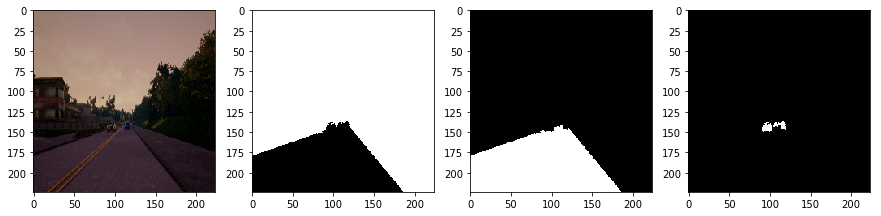

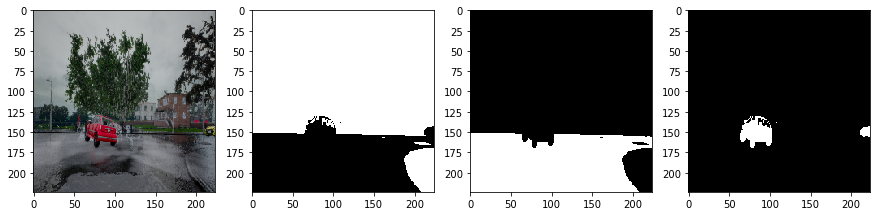

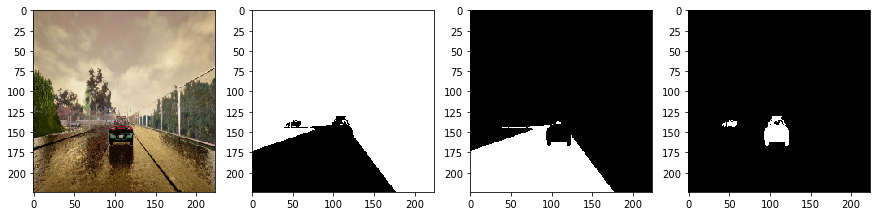

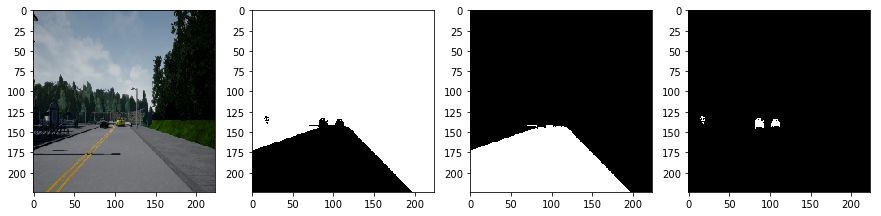

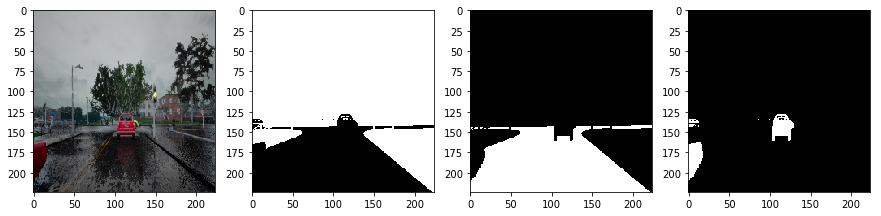

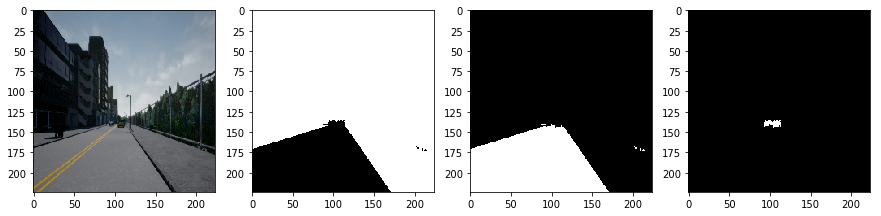

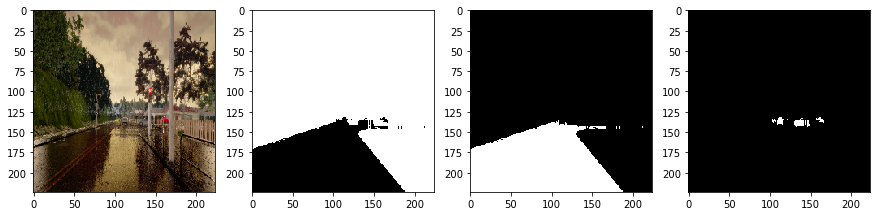

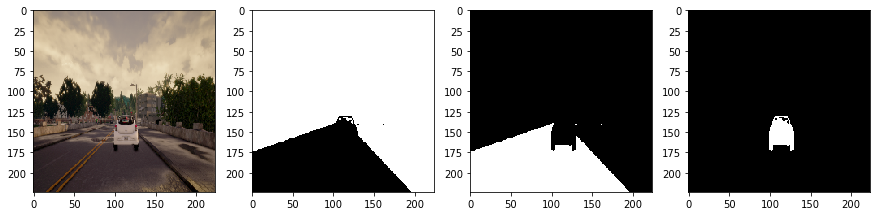

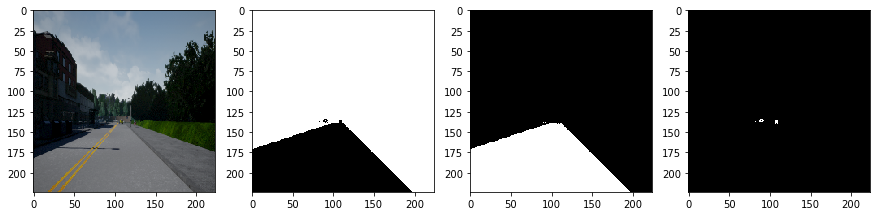

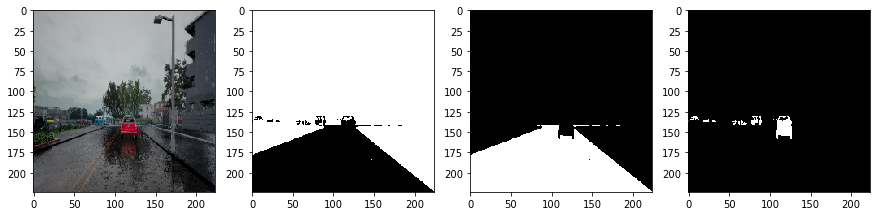

In [2]:
batch = fn(10)

imgs = next(batch)

for i in range(len(imgs[0])):
    plt.figure(figsize=(15,15))
    plt.subplot(241), plt.imshow(imgs[0][i])
    plt.subplot(242), plt.imshow(imgs[1][i][:, :, 0], cmap='gray')
    plt.subplot(243), plt.imshow(imgs[1][i][:, :, 1], cmap='gray')
    plt.subplot(244), plt.imshow(imgs[1][i][:, :, 2], cmap='gray')
    plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 12]
[0 1 2]


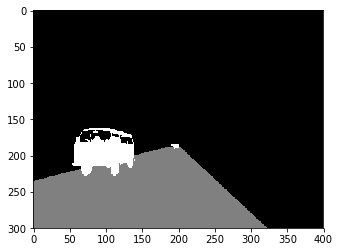

In [159]:
# Test remap_seg function

seg_file = '../lyft_training_data/Train/CameraSeg/17.png'
seg = cv2.resize(cut_hood(cv2.imread(seg_file, cv2.IMREAD_COLOR)[:, :, 2], \
                                   perc_retain=0.83),
                 IMAGE_SIZE,
                 interpolation=cv2.INTER_NEAREST)
print(np.unique(seg))
seg1 = remap_seg(seg, SEG_MAP)
print(np.unique(seg1))
plt.imshow(seg1, cmap='gray')

In [57]:
x = np.array([1, 2, 2, 1, 3])

c = [2, 3]

x[~np.isin(x, c)] = 0
x

array([0, 2, 2, 0, 3])